## Hartman 6d function

In [1]:
import jax
import numpy as np
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from functools import partial
from jaxopt import ProjectedGradient
from rebayes_mini.methods import low_rank_last_layer as lrll

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_palette("colorblind")

In [4]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.figsize"] = (7.2, 4.2)

In [5]:
jnp.set_printoptions(suppress=True, precision=5, linewidth=200)

In [6]:
def hartmann6(x):
    """
    Evaluates the 6-dimensional Hartmann function at point x.
    :param x: A numpy array of shape (6,)
    :return: Function value at x
    """
    # Coefficients
    alpha = jnp.array([1.0, 1.2, 3.0, 3.2])
    A = jnp.array([
        [10, 3, 17, 3.50, 1.7, 8],
        [0.05, 10, 17, 0.1, 8, 14],
        [3, 3.5, 1.7, 10, 17, 8],
        [17, 8, 0.05, 10, 0.1, 14]
    ])
    P = 1e-4 * jnp.array([
        [1312, 1696, 5569, 124, 8283, 5886],
        [2329, 4135, 8307, 3736, 1004, 9991],
        [2348, 1451, 3522, 2883, 3047, 6650],
        [4047, 8828, 8732, 5743, 1091, 381]
    ])
    
    # Compute function value
    sum_terms = jnp.sum(A * (x - P) ** 2, axis=1)
    exp_terms = jnp.exp(-sum_terms)
    result = -jnp.sum(alpha * exp_terms)
    
    return result

# Example usage:
x_test = jnp.array([0.2, 0.4, 0.6, 0.8, 0.3, 0.5])
x_opt = jnp.array([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])

print(hartmann6(x_test))

-0.1961809


In [7]:
x_opt = jnp.array([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
print(hartmann6(x_opt))

-3.322363


## The BNN surrogate model

In [8]:
class MLP(nn.Module):
    n_hidden: int = 180

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        # x = jnp.sin(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(self.n_hidden)(x)
        x = nn.elu(x)
        x = nn.Dense(1, name="last_layer")(x)
        return x

In [9]:
def projection(params, hparams):
    return jnp.clip(params, 0.0, 1.0)


def minimise_project(guess_init, params_hidden, params_ll, agent):
    fn_sampled = lambda x: -agent.mean_fn(params_hidden, params_ll, x).squeeze()
    opt = ProjectedGradient(
        fun=fn_sampled,
        projection=projection,  # Enforce boundary constraints
        stepsize=1e-5,
        tol=1e-5,
        maxiter=1000,
    )
    res = opt.run(guess_init)
    return res

def step(state, t, key, agent, guess_init=None):
    bel, x, y, y_best = state
    key_step = jax.random.fold_in(key, t)
    key_step, key_guess = jax.random.split(key_step)
    guess_init = x_test
    # guess_init = jax.random.uniform(key_step, shape=(6,), minval=0, maxval=1)

    ll_params = agent.sample_params_last_layer(key_step, bel).squeeze()
    # compute location of next best estimate and actual estimate
    x_next = minimise_project(guess_init, bel.mean_hidden, ll_params, agent).params
    y_next = -hartmann6(x_next).squeeze()
    # update belief based on true observations
    bel = agent.update(bel, y_next.squeeze(), x_next)

    y_best = y_next * (y_next > y_best) + y_best * (y_next <= y_best)

    out = {
        "x": x_next.squeeze(),
        "y": y_next.squeeze(),
        "y_best": y_best.squeeze()
    }

    state_next = (bel, x_next, y_next, y_best)
    return state_next, out

## Optimise!

In [146]:
key = jax.random.PRNGKey(314)
key_init_params, key_init_x, key_eval = jax.random.split(key, 3)

In [168]:
surrogate = MLP()
params_init = surrogate.init(key_init_params, x_test)

def cov_fn(y): return 0.0
agent = lrll.LowRankLastLayer(
    surrogate.apply, cov_fn, rank=50, dynamics_hidden=0.0, dynamics_last=0.0,
)

bel_init = agent.init_bel(
    params_init,
    cov_hidden=1e-3, # parameters do not vary much from their initial parameters
    cov_last=1.0 # uncertainty in target
)

In [169]:
def orthogonal(key, n, m):
    z = jax.random.normal(key, (max(n, m), min(n, m)))
    q, r = jnp.linalg.qr(z)
    d = jnp.linalg.diagonal(r)
    x = q * jnp.expand_dims(jnp.sign(d), -2)
    return x.T

In [170]:
bel_init = bel_init.replace(
    loading_hidden=W * 1e-6
)

In [171]:
x_next = jax.random.uniform(key_init_x, shape=(6,), minval=0, maxval=1)
y_next = hartmann6(x_next)

In [172]:
steps = jnp.arange(100)
state_init = (bel_init, x_next, y_next, y_next)
_eval = partial(step, key=key_eval, agent=agent)
bel_final, hist = jax.lax.scan(_eval, state_init, steps)

In [173]:
x_opt = jnp.array([0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573])
y_opt = -hartmann6(x_opt)

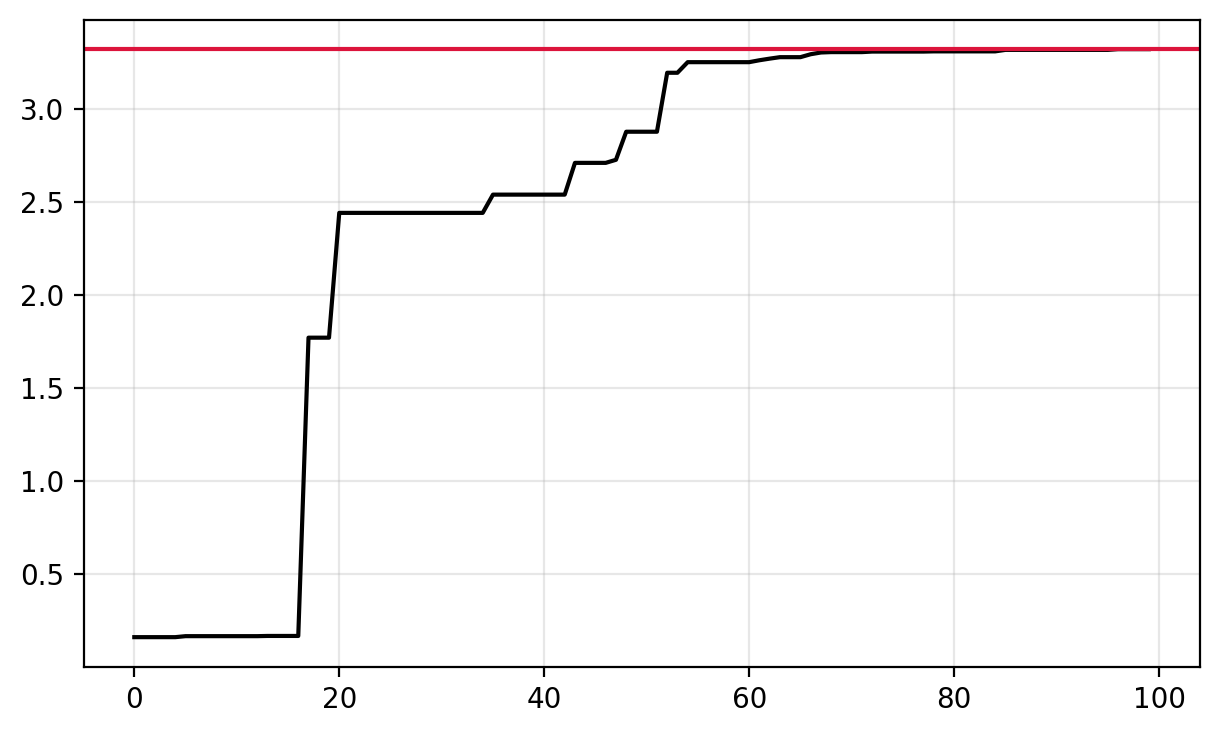

In [178]:
plt.plot(hist["y_best"], c="black")
plt.axhline(y=y_opt, c="crimson")
plt.grid(alpha=0.3)